In [ ]:
import re
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
def parse_sioux_falls_data(filename, filetype):
	"""
	Parse Sioux Falls transportation network data files into pandas DataFrames.
	
	Parameters:
	-----------
	filename : str
		Path to the file to be parsed
	filetype : str
		Type of file to parse. Options: 'net', 'node', 'flow'
		
	Returns:
	--------
	pd.DataFrame
		Parsed data as a pandas DataFrame
		
	Raises:
	-------
	ValueError
		If filetype is not one of the supported types
	FileNotFoundError
		If the specified file cannot be found
	"""
	
	if filetype not in ['net', 'node', 'flow']:
		raise ValueError("filetype must be one of: 'net', 'node', 'flow'")
	
	try:
		with open(filename, 'r') as file:
			content = file.read()
	except FileNotFoundError:
		raise FileNotFoundError(f"File '{filename}' not found")
	
	if filetype == 'node':
		return _parse_node_file(content)
	elif filetype == 'net':
		return _parse_net_file(content)
	elif filetype == 'flow':
		return _parse_flow_file(content)

def _parse_node_file(content):
	"""Parse node coordinate file"""
	lines = content.strip().split('\n')
	
	# Skip header line and parse data
	data = []
	for line in lines[1:]:  # Skip header
		if line.strip() and not line.strip().startswith(';'):
			# Remove trailing semicolon and split
			parts = line.replace(';', '').strip().split('\t')
			if len(parts) >= 3:
				try:
					node_id = int(parts[0])
					x_coord = float(parts[1])
					y_coord = float(parts[2])
					data.append([node_id, x_coord, y_coord])
				except ValueError:
					continue  # Skip malformed lines
	
	return pd.DataFrame(data, columns=['Node', 'X', 'Y'])

def _parse_net_file(content):
	"""Parse network file with metadata and link data"""
	lines = content.strip().split('\n')
	
	# Find where the actual data starts (after <END OF METADATA>)
	data_start_idx = None
	for i, line in enumerate(lines):
		if '<END OF METADATA>' in line:
			data_start_idx = i + 2  # Skip metadata end line and column header
			break
	
	if data_start_idx is None:
		raise ValueError("Could not find <END OF METADATA> marker in net file")
	
	# Parse the link data
	data = []
	for line in lines[data_start_idx:]:
		if line.strip() and not line.strip().startswith('~') and line.strip() != ';':
			# Remove leading/trailing whitespace and semicolon
			parts = line.replace(';', '').strip().split('\t')
			# Filter out empty parts
			parts = [part.strip() for part in parts if part.strip()]
			
			if len(parts) >= 10:  # Ensure we have all required columns
				try:
					data.append([
						int(parts[0]),      # init_node
						int(parts[1]),      # term_node  
						float(parts[2]),    # capacity
						float(parts[3]),    # length
						float(parts[4]),    # free_flow_time
						float(parts[5]),    # b
						float(parts[6]),    # power
						float(parts[7]),    # speed
						float(parts[8]),    # toll
						int(parts[9])       # link_type
					])
				except (ValueError, IndexError):
					continue  # Skip malformed lines
	
	columns = ['init_node', 'term_node', 'capacity', 'length', 'free_flow_time', 
			   'b', 'power', 'speed', 'toll', 'link_type']
	
	return pd.DataFrame(data, columns=columns)

def _parse_flow_file(content):
	"""Parse flow file with origin-destination flow data"""
	lines = content.strip().split('\n')
	
	# Skip header line and parse data
	data = []
	for line in lines[1:]:  # Skip header
		if line.strip():
			# Split by whitespace/tabs
			parts = line.strip().split()
			if len(parts) >= 4:
				try:
					from_node = int(parts[0])
					to_node = int(parts[1])
					volume = float(parts[2])
					cost = float(parts[3])
					data.append([from_node, to_node, volume, cost])
				except ValueError:
					continue  # Skip malformed lines
	
	return pd.DataFrame(data, columns=['From', 'To', 'Volume', 'Cost'])

In [3]:
node_file = 'SiouxFalls_node.tntp'
net_file = 'SiouxFalls_net.tntp'
flow_file = 'SiouxFalls_flow.tntp'

In [4]:
# Parse node file
nodes_df = parse_sioux_falls_data(node_file, 'node')
print("Nodes DataFrame:")
print(nodes_df.head())
print(f"Shape: {nodes_df.shape}\n")

# Parse network file  
network_df = parse_sioux_falls_data(net_file, 'net')
print("Network DataFrame:")
print(network_df.head())
print(f"Shape: {network_df.shape}\n")

# Parse flow file
flow_df = parse_sioux_falls_data(flow_file, 'flow')
print("Flow DataFrame:")
print(flow_df.head())
print(f"Shape: {flow_df.shape}\n")



Nodes DataFrame:
   Node          X          Y
0     1 -96.770420  43.612828
1     2 -96.711251  43.605813
2     3 -96.774303  43.572962
3     4 -96.747168  43.563654
4     5 -96.731569  43.564034
Shape: (24, 3)

Network DataFrame:
   init_node  term_node      capacity  length  free_flow_time     b  power  \
0          1          2  25900.200640     6.0             6.0  0.15    4.0   
1          1          3  23403.473190     4.0             4.0  0.15    4.0   
2          2          1  25900.200640     6.0             6.0  0.15    4.0   
3          2          6   4958.180928     5.0             5.0  0.15    4.0   
4          3          1  23403.473190     4.0             4.0  0.15    4.0   

   speed  toll  link_type  
0    0.0   0.0          1  
1    0.0   0.0          1  
2    0.0   0.0          1  
3    0.0   0.0          1  
4    0.0   0.0          1  
Shape: (76, 10)

Flow DataFrame:
   From  To       Volume      Cost
0     1   2  4494.657646  6.000816
1     1   3  8119.079948  4.

In [5]:
def create_sioux_falls_graph(net_file, node_file):
	"""
	Create a NetworkX graph from Sioux Falls network and node files.
	
	Parameters:
	-----------
	net_file : str
		Path to the network file
	node_file : str
		Path to the node coordinate file
		
	Returns:
	--------
	nx.MultiDiGraph
		NetworkX directed graph with node positions and edge attributes
	dict
		Node positions dictionary for visualization
	"""
	
	# Parse the data files
	net_df = parse_sioux_falls_data(net_file, 'net')
	node_df = parse_sioux_falls_data(node_file, 'node')
	
	# Create directed multigraph (allows multiple edges between same nodes)
	G = nx.MultiDiGraph()
	
	# Add nodes with coordinates
	pos = {}
	for _, row in node_df.iterrows():
		node_id = int(row['Node'])
		x, y = float(row['X']), float(row['Y'])
		G.add_node(node_id, x=x, y=y)
		pos[node_id] = (x, y)
	
	# Add edges with attributes
	for _, row in net_df.iterrows():
		init_node = int(row['init_node'])
		term_node = int(row['term_node'])
		
		# Add edge with all attributes
		G.add_edge(init_node, term_node,
				   capacity=row['capacity'],
				   length=row['length'],
				   free_flow_time=row['free_flow_time'],
				   b=row['b'],
				   power=row['power'],
				   speed=row['speed'],
				   toll=row['toll'],
				   link_type=row['link_type'])
	
	return G, pos

def visualize_network(G, pos, title="Sioux Falls Transportation Network", figsize=(12, 10)):
	"""
	Visualize the basic network structure.
	
	Parameters:
	-----------
	G : nx.Graph
		NetworkX graph
	pos : dict
		Node positions
	title : str
		Plot title
	figsize : tuple
		Figure size
	"""
	
	plt.figure(figsize=figsize)
	
	# Draw nodes
	nx.draw_networkx_nodes(G, pos, 
						  node_color='lightblue', 
						  node_size=300,
						  alpha=0.8)
	
	# Draw edges
	nx.draw_networkx_edges(G, pos, 
						  edge_color='gray',
						  alpha=0.6,
						  arrows=True,
						  arrowsize=10,
						  arrowstyle='->')
	
	# Draw node labels
	nx.draw_networkx_labels(G, pos, 
						   font_size=8,
						   font_weight='bold')
	
	plt.title(title, fontsize=14, fontweight='bold')
	plt.xlabel("Longitude")
	plt.ylabel("Latitude")
	# Add a north arrow (compass)
	x_min, x_max = plt.xlim()
	y_min, y_max = plt.ylim()
	x_loc = x_max - (x_max - x_min) * 0.05
	y_loc = y_min + (y_max - y_min) * 0.98

	plt.annotate('',
								xy=(x_loc, y_loc),
								xytext=(x_loc, y_loc - (y_max - y_min) * 0.05),
								arrowprops=dict(facecolor='black', width=2, headwidth=8),
								ha='center', va='center', fontsize=12, fontweight='bold')
	# Place 'N' above arrow head
	plt.text(x_loc, y_loc , "N",
					ha="center", va="bottom", fontsize=12, fontweight="bold")
	plt.tight_layout()
	plt.savefig("sioux_falls_network.pdf", dpi=300)
	plt.show()


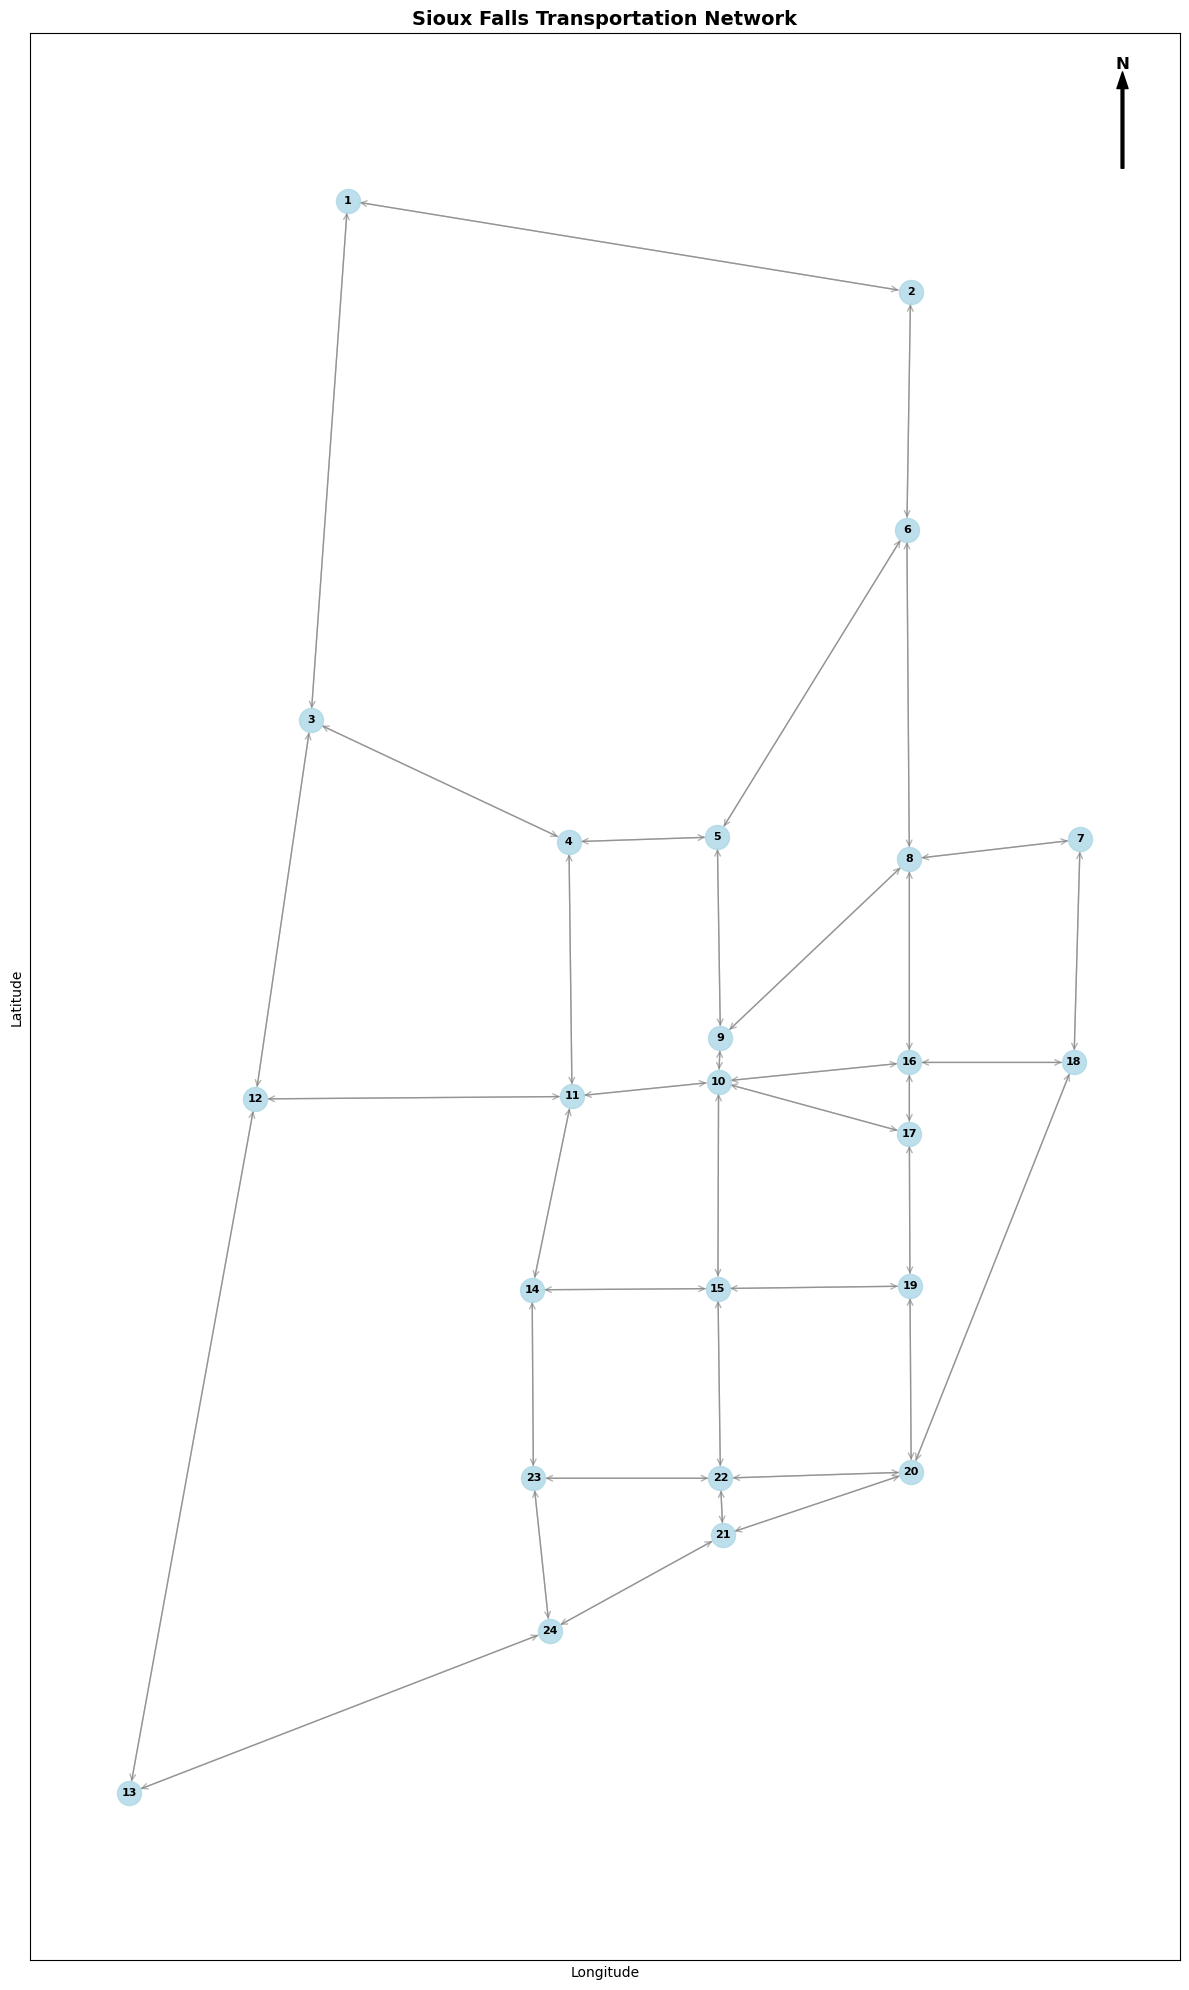

In [6]:
G, pos = create_sioux_falls_graph(net_file, node_file)
visualize_network(G, pos, figsize=(12, 20))